In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV



In [36]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eugem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
# Load data
df = pd.read_csv("data/Amazon_Unlocked_Mobile.csv")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413770 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


Prepare the data

In [39]:
df = df.drop_duplicates()

In [40]:
# Convert brand names to lowercase if the value is a string
df["Brand Name"] = df["Brand Name"].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [41]:
# Convert product names to lowercase
df["Product Name"] = df["Product Name"].str.lower()


In [42]:
brands = [
    "samsung", "apple", "blu", "lg", "nokia", "blackberry", "motorola", "cnpgd", "htc", "sony", "otterbox", 
    "posh mobile", "huawei", "lg electronics", "lenovo", "asus", "zte", "polaroid", "alcatel", "verykool", 
    "casio", "figo", "pantech", "ultrabox", "star", "microsoft", "sky devices", "kyocera", "sandisk", "ecoopro", 
    "oneplus", "nextbit", "honor", "juning", "hipipooo"
]


def complete_brand_name(row):
    if pd.isna(row["Brand Name"]):  
        for brand in brands:
            if brand in row["Product Name"]:
                return brand  
    return row["Brand Name"]

df["Brand Name"] = df.apply(complete_brand_name, axis=1)

In [ ]:
# complete "Brand Name"  looking words like "moto" o "iphone" at "Product Name"
df.loc[df["Product Name"].str.contains("moto", case=False, na=False), "Brand Name"] = "motorola"
df.loc[df["Product Name"].str.contains("iphone", case=False, na=False), "Brand Name"] = "apple"

In [44]:
# Fill missing values in 'Review Votes' with 0 and convert to integer type

df['Review Votes'] = df['Review Votes'].fillna(0).astype(int)

In [ ]:
# Delete null valuees  'Brand Name' or 'Price'
df.dropna(subset=['Brand Name', 'Price','Reviews'], inplace=True)

Preprocessing

In [46]:
# Initialize the Porter Stemmer for word stemming
ps = PorterStemmer()

# Load stopwords in English
stop_words = set(stopwords.words('english'))

# Create an empty list to store preprocessed text
corpus = []

# Iterate through all reviews in the dataset
for review in df['Reviews']:
    # Convert non-alphabetic characters to spaces
    cleaned_review = re.sub(r'[^a-zA-Z]', ' ', str(review))

    # Convert the text to lowercase and split into words
    words = cleaned_review.lower().split()

    # Remove stopwords and apply stemming
    processed_words = [ps.stem(word) for word in words if word not in stop_words]

    # Join the processed words back into a single string
    corpus.append(' '.join(processed_words))


In [48]:
# Function to reassign ratings into 3 sentiment categories
def categorize_sentiment(rating):
    if rating <= 2:
        return 0  # Negative sentiment
    elif rating == 3:
        return 1  # Neutral sentiment
    else:
        return 2  # Positive sentiment

# Apply the function to create a new 'Sentiment' column
df['Sentiment'] = df['Rating'].apply(categorize_sentiment)  # This was modified

In [61]:
df.to_csv('preprocessed_data.csv', index=False)

In [18]:
# Initialize the tokenizer with a vocabulary size limit of 5000 words
tokenizer = Tokenizer(num_words=5000)

# Fit the tokenizer on the preprocessed text corpus
tokenizer.fit_on_texts(corpus)

# Convert the text corpus into sequences of numerical tokens
X = tokenizer.texts_to_sequences(corpus)

# Pad sequences to ensure they have the same length (max length: 100)
X = pad_sequences(X, maxlen=100)


In [19]:
import pickle

# Guardar el tokenizador en un archivo .pkl
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [21]:
# Convert to categotical
y = to_categorical(df['Sentiment'], num_classes=3) 

# Split the data train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax')) 

c:\Users\eugem\anaconda3\envs\env_full\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### **Why Use LSTM?**  
LSTMs are ideal for sequential data like text because they retain long-term dependencies, making them effective for sentiment analysis. They help understand context and word relationships in reviews.  

### **Model Breakdown**  
- **Embedding Layer:** Converts words into 128-dimensional dense vectors, with a vocabulary size of 5000 and sequence length of 100.  
- **LSTM (100, return_sequences=True):** Captures word dependencies while passing the sequence to the next layer.  
- **Dropout (0.2):** Prevents overfitting by randomly deactivating 20% of neurons.  
- **LSTM (100):** Processes the sequence and outputs a final hidden state.  
- **Dropout (0.2):** Further regularization to improve generalization.  
- **Dense (3, softmax):** Outputs probabilities for the three sentiment classes (negative, neutral, positive).  

This architecture balances feature extraction, context retention, and regularization for robust sentiment classification.

In [23]:
# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Callbacks: Early Stopping y Checkpoint
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')


In [25]:
# Entrenamiento del modelo con callbacks
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1076s 124ms/step - accuracy: 0.8410 - loss: 0.4416 - val_accuracy: 0.8703 - val_loss: 0.3576
Epoch 2/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1275s 149ms/step - accuracy: 0.8831 - loss: 0.3326 - val_accuracy: 0.8805 - val_loss: 0.3381
Epoch 3/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1321s 154ms/step - accuracy: 0.8986 - loss: 0.2928 - val_accuracy: 0.8917 - val_loss: 0.3191
Epoch 4/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1281s 149ms/step - accuracy: 0.9147 - loss: 0.2537 - val_accuracy: 0.8984 - val_loss: 0.3079
Epoch 5/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1153s 134ms/step - accuracy: 0.9273 - loss: 0.2217 - val_accuracy: 0.9044 - val_loss: 0.3013
Epoch 6/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1586s 185ms/step - accuracy: 0.9379 - loss: 0.1943 - val_accuracy: 0.9077 - val_loss: 0.3081
Epoch 7/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1013s 118ms/step - accuracy: 0.9448 - loss: 0.1742 - val_accuracy: 0.9087 - val_loss: 0.2985
Epoch 8/20
8574/8574 ━━━━━━━━━━━━━━━━━━━━ 1025s 120ms/s

In [55]:
# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


NameError: name 'model' is not defined

In [56]:
# Matriz de confusión
y_pred = model.predict(X_test)  # esto cambio
y_pred_labels = np.argmax(y_pred, axis=1)  # esto cambio
y_true_labels = np.argmax(y_test, axis=1)  # esto cambio
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)  # esto cambio


NameError: name 'model' is not defined

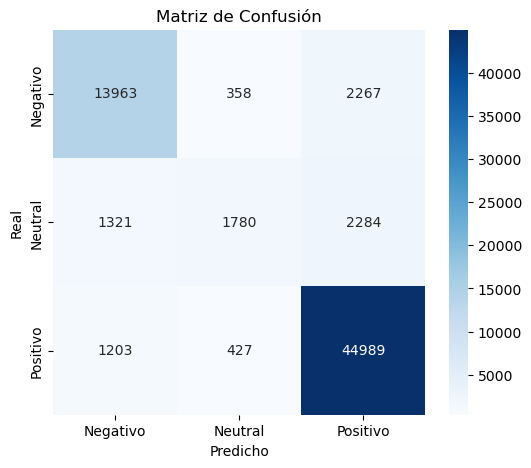

In [51]:
# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))  # esto cambio
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])  # esto cambio
plt.xlabel('Predicho')  # esto cambio
plt.ylabel('Real')  # esto cambio
plt.title('Matriz de Confusión')  # esto cambio
plt.show()  # esto cambio



In [29]:
print(classification_report(y_true_labels, y_pred_labels, target_names=['Negativo', 'Neutral', 'Positivo']))  # esto cambio


              precision    recall  f1-score   support

    Negativo       0.89      0.89      0.89     16588
     Neutral       0.68      0.57      0.62      5385
    Positivo       0.95      0.96      0.95     46619

    accuracy                           0.92     68592
   macro avg       0.84      0.81      0.82     68592
weighted avg       0.91      0.92      0.91     68592



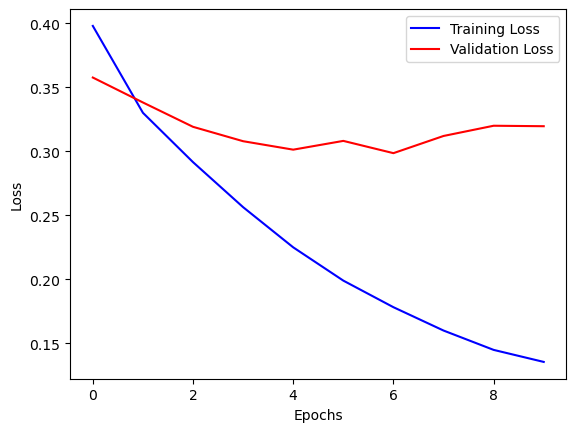

In [30]:
# Visualize the loss during training
plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

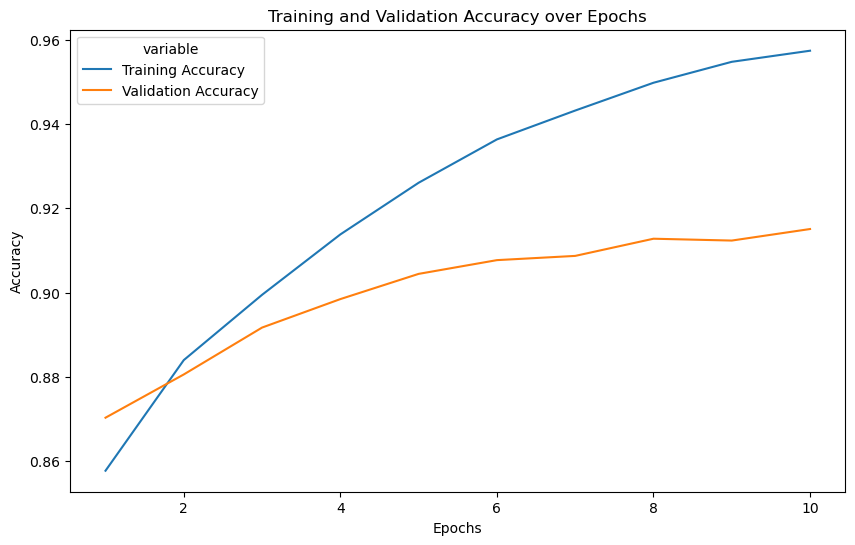

In [31]:
# Create a DataFrame with accuracy and validation accuracy data
accuracy_data = pd.DataFrame({
    'Epochs': range(1, len(history.history['accuracy']) + 1),
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy']
})

# Use Seaborn to visualize the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epochs', y='value', hue='variable', data=pd.melt(accuracy_data, ['Epochs']))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.show()

In [32]:
model.save('./amazon_model.h5')


In [33]:
model.save('./amazon_model.keras')

In [34]:
model.export("amazon_model_lstm")


INFO:tensorflow:Assets written to: amazon_model_lstm\assets


INFO:tensorflow:Assets written to: amazon_model_lstm\assets


Saved artifact at 'amazon_model_lstm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2103057330064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103057329680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103057330256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103054405648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103054405840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103054406416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103054405264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103054406992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2103116938896: TensorSpec(shape=(), dtype=tf.resource, name=None)


## LINEAR REGRESSION MODEL

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342957 entries, 0 to 413829
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  342957 non-null  object 
 1   Brand Name    342957 non-null  object 
 2   Price         342957 non-null  float64
 3   Rating        342957 non-null  int64  
 4   Reviews       342957 non-null  object 
 5   Review Votes  342957 non-null  int32  
 6   Sentiment     342957 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 19.6+ MB


In [80]:
# Use CountVectorizer to convert text data into numerical data
vectorizer = CountVectorizer(stop_words='english')
X_LR = vectorizer.fit_transform(df['Reviews'])

# Labels (Sentiment)
y_LR = df['Sentiment']

In [81]:
# Split the dataset into training and testing sets
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_LR, y_LR, test_size=0.2, random_state=42)

In [82]:
param_grid = {
    'C': [0.1, 1, 10],        # Menos valores para explorar
    'penalty': ['l2'],         # Solo Ridge (menos costoso computacionalmente)
    'solver': ['liblinear']    # Se mantiene porque es eficiente para conjuntos de datos pequeños/medianos
}

In [ ]:
model_LR = LogisticRegression(max_iter=1000)

In [ ]:
# Config  GridSearchCV
grid_search = GridSearchCV(
    estimator=model_LR,        # Model
    param_grid=param_grid,     # Hiperparam to explore
    cv=5,                      # Cross validation 5 folds
    scoring='accuracy',        # Metric
    n_jobs=-1                  
)
# Train GridSearchCV
grid_search.fit(X_train_LR, y_train_LR)


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


c:\Users\eugem\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Predictions
y_pred_LR = best_model.predict(X_test_LR)

# Metrics
print("Accuracy:", accuracy_score(y_test_LR, y_pred_LR))
print(classification_report(y_test_LR, y_pred_LR))

Accuracy: 0.885409377186844
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     16588
           1       0.69      0.33      0.45      5385
           2       0.91      0.97      0.94     46619

    accuracy                           0.89     68592
   macro avg       0.82      0.71      0.74     68592
weighted avg       0.88      0.89      0.88     68592



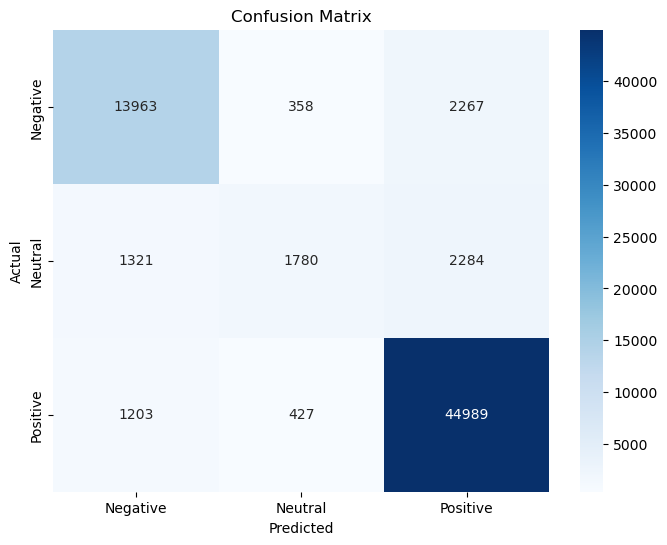

In [21]:
# Create a confusion matrix to visualize the model's performance
conf_matrix = confusion_matrix(y_test_LR, y_pred_LR)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Predict
y_pred_LR = best_model.predict(X_test_LR)

# Concert y_pred_LR to a DataFrame 
predictions_df = pd.DataFrame(y_pred_LR, columns=['Prediction'], index=y_test_LR.index)


result_df = df.loc[y_test_LR.index].copy()
result_df['Prediction'] = predictions_df['Prediction']



In [93]:
result_df.to_csv('result_data.csv', index=False)

CREATE DATA PRODUCTION to test evidently

In [ ]:
# data reference
df_production = df

df_production.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
0,"""clear clean esn"" sprint epic 4g galaxy sph-d7...",samsung,207.007925,4,I feel so LUCKY to have found this used (phone...,1.0,2
1,"""clear clean esn"" sprint epic 4g galaxy sph-d7...",NewBrandXYZ,265.104762,4,"nice phone, nice up grade from my pantach revu...",0.0,2
2,"""clear clean esn"" sprint epic 4g galaxy sph-d7...",samsung,271.053492,4,Very pleased,NaN,2
3,"""clear clean esn"" sprint epic 4g galaxy sph-d7...",samsung,258.947025,4,It works good but it goes slow sometimes but i...,0.0,2
4,"""clear clean esn"" sprint epic 4g galaxy sph-d7...",samsung,263.354799,3,Great phone to replace my lost phone. The only...,0.0,2


In [32]:
df_production.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342957 entries, 0 to 413829
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  342957 non-null  object 
 1   Brand Name    342957 non-null  object 
 2   Price         342957 non-null  float64
 3   Rating        342957 non-null  int64  
 4   Reviews       342957 non-null  object 
 5   Review Votes  308661 non-null  float64
 6   Sentiment     342957 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 29.0+ MB


In [33]:
# Simulate drift in 'Price' by multiplying with random values between 0.9 and 1.5
df_production['Price'] = df_production['Price'] * np.random.uniform(0.9, 1.5, size=len(df_production))
# Reason: Prices in production may fluctuate due to promotions, inflation, or pricing errors

# Simulate drift in 'Rating' by modifying the values with a random factor between 0.8 and 1.2
df_production['Rating'] = df_production['Rating'].apply(
    lambda x: min(5, max(1, int(x * np.random.uniform(0.8, 1.2))))
)
# Reason: Ratings might shift in production due to changes in customer satisfaction or review manipulation

# Introduce missing values (NaNs) in 10% of the 'Review Votes' column
nan_indices = df_production.sample(frac=0.1, random_state=42).index  # Select 10% of the rows
df_production.loc[nan_indices, 'Review Votes'] = np.nan
# Reason: In real production scenarios, data ingestion pipelines may generate missing values unexpectedly

# Save the simulated production dataset to a CSV file
df_production.to_csv('production_data.csv', index=False)
# Reason: This file will be used as the production dataset in the monitoring process

### Simulating a Production Dataset for Data Drift and Quality Monitoring

In real-world machine learning applications, data received in production often differs from the training data (reference dataset). These differences can result in **data drift**, **concept drift**, and **data quality issues**, which may lead to degraded model performance or system failures. 

To prepare for such scenarios, we created a **simulated production dataset** with intentional modifications. This allows us to test data monitoring tools like **Evidently AI**, evaluate the system's robustness, and detect potential issues early.

---

### Step-by-Step Explanation

 1. Start from a Clean Reference Dataset : *loaded and copied** the clean dataset, which represents the data used for training and model validation. This ensures we are starting from a controlled and known distribution.
 2. We modified the Price column by multiplying it with random values ranging from 0.9 to 1.5. This simulates:
    - Inflation or price updates
    - Seasonal discounts or promotions
    - Data inconsistencies from upstream sources
3. We altered the Rating column by randomly scaling the values and bounding them between 1 and 5. This emulates:
    - Changing user perceptions
    - Manipulated or biased reviews
    - Review policy changes
4. We introduced NaN values in 10% of the Review Votes data, simulating:
    - Data ingestion issues
    - Optional fields not being filled
    - Broken API integrations or ETL errors
5. We saved the simulated production dataset to a CSV file




### Conclusion of the Project

The **LSTM model** outperforms the **linear regression model** across all key metrics, especially in precision and recall for the minority class (*Neutral*). This suggests that the LSTM model has a better ability to capture complex patterns in textual data.  

- **Overall accuracy**: The LSTM model achieves **92% accuracy**, compared to **88.5% for linear regression**.  
- **Minority class performance**: The *Neutral* class remains the most challenging to predict, but there is a notable improvement in recall (from **33% in linear regression** to **57% with LSTM**).  
- **Class balance**: The LSTM model achieves a better balance between precision and recall across all categories, indicating less bias towards the majority class (*Positive*).  

---

### Possible Improvements  

Since the LSTM model **takes significantly longer to train**, it is essential to assess whether the increase in accuracy justifies the computational cost. Some improvements to optimize performance include:  

1. **LSTM Model Optimization**  
   - Experimenting with different architectures, such as adding more layers or adjusting the network size.  
   - Using techniques like *Batch Normalization* or *Dropout* to improve generalization.  
   - Tuning key hyperparameters such as batch size, learning rate, and the number of LSTM units.  

2. **Better Handling of the Minority Class (*Neutral*)**  
   - Applying data balancing techniques like *oversampling* or *SMOTE*.  
   - Adjusting the loss function to give more weight to the minority class.  

3. **Exploring Other Models**  
   - Evaluating more efficient models like **Transformer-based architectures** (*BERT, DistilBERT*), which may achieve similar accuracy with shorter training times.  
   - Implementing a **Convolutional Neural Network (CNN) for text**, which in some cases can be faster and more effective than an LSTM.  

4. **Using Pretrained Embeddings**  
   - Implementing *Word2Vec, GloVe, or FastText* to enhance word representation in the LSTM model.  

If training time remains an issue, another option could be to explore a **hybrid model**, combining advanced embeddings with a simpler classifier like a **Deep Neural Network (DNN)** or **Support Vector Machine (SVM)**.  
